In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import root_mean_squared_error, r2_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import KFold
from model.cnn1d.CNN1D import CNN1D
from sklearn.inspection import permutation_importance
import seaborn as sns
from sklearn.metrics import make_scorer, root_mean_squared_error
import shap
import matplotlib.pyplot as plt

In [2]:
trn = pd.read_csv("../data/processed/trn.feat.csv")
tst_08SC = pd.read_csv("../data/processed/tst.08SC.feat.csv")
tst1_19SC = pd.read_csv("../data/processed/tst.19SC.1.feat.csv")
tst2_19SC = pd.read_csv("../data/processed/tst.19SC.2.feat.csv")

trn_y, trn_X = trn["Solubility"], trn.drop(["Solubility", "Name", "SMILES"], axis=1)
tst_08SC_y, tst_08SC_X = tst_08SC["Solubility"], tst_08SC.drop(["Solubility", "Name", "SMILES"], axis=1)
tst1_19SC_y, tst1_19SC_X = tst1_19SC["Solubility"], tst1_19SC.drop(["Solubility", "Name", "SMILES"], axis=1)
tst2_19SC_y, tst2_19SC_X = tst2_19SC["Solubility"], tst2_19SC.drop(["Solubility", "Name", "SMILES"], axis=1)

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=2387)

pred_19t1, pred_19t2, pred_08t = [], [], []
models = []

for trn_idx, val_idx in kf.split(trn_X):
    tX, vX = trn_X.loc[trn_idx], trn_X.loc[val_idx]
    ty, vy = trn_y[trn_idx], trn_y[val_idx]

    model = CNN1D(
        n_tasks=1,
        in_feats=tX.shape[1],
        weight_decay=0.01
    )

    scores = model.fit(tX, ty, val_X=vX, val_y=vy,
                       max_epochs=1000, min_epochs=500, early_stop=20, batch_size=1024)

    if scores["val_rmse"][-1] > 5:
        continue
    
    pred_validation = model.predict(vX)

    pred_19t1.append(model.predict(tst1_19SC_X))
    pred_19t2.append(model.predict(tst2_19SC_X))
    pred_08t.append(model.predict(tst_08SC_X))
    models.append(model)

In [4]:
pred_19t1 = np.mean(pred_19t1, axis=0)
pred_19t2 = np.mean(pred_19t2, axis=0)
pred_08t = np.mean(pred_08t, axis=0)

In [5]:
performance = {
    "2019SC TST1 (RMSE)": root_mean_squared_error(tst1_19SC_y, pred_19t1),
    "2019SC TST2 (RMSE)": root_mean_squared_error(tst2_19SC_y, pred_19t2),
    "2008SC TST  (RMSE)": root_mean_squared_error(tst_08SC_y, pred_08t),
    "2019SC TST1 (R^2)": r2_score(tst1_19SC_y, pred_19t1),
    "2019SC TST2 (R^2)": r2_score(tst2_19SC_y, pred_19t2),
    "2008SC TST  (R^2)": r2_score(tst_08SC_y, pred_08t),
}
performance

{'2019SC TST1 (RMSE)': 0.7216386319474604,
 '2019SC TST2 (RMSE)': 1.4976157525961487,
 '2008SC TST  (RMSE)': 0.9118506968448005,
 '2019SC TST1 (R^2)': 0.5711016564379927,
 '2019SC TST2 (R^2)': 0.44248251072413813,
 '2008SC TST  (R^2)': 0.5485117817083665}

Text(0.5, 1.0, '08SC (1DCNN)   RMSE: 0.912, $R^2$: 0.549')

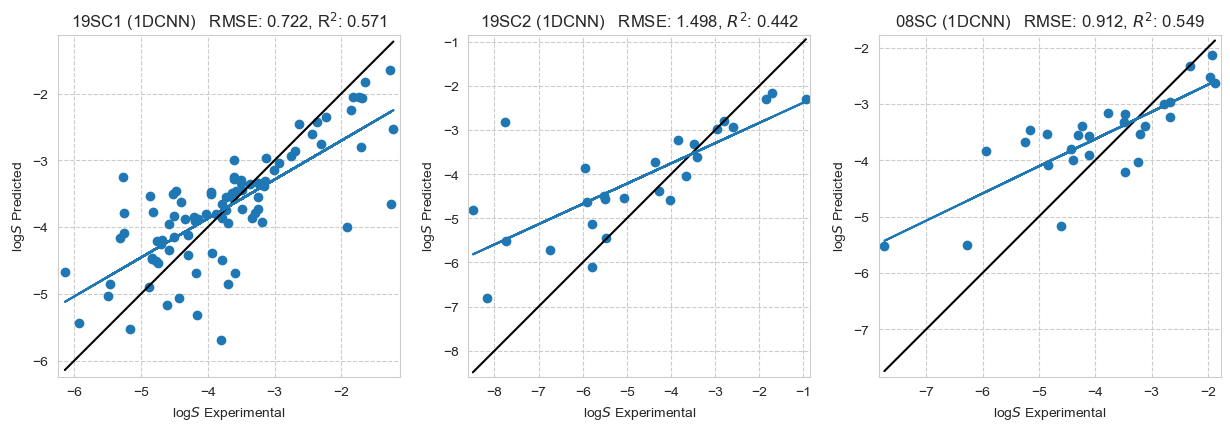

In [6]:
import matplotlib.pyplot as plt


def subplot(x, y, ax):
    ax.scatter(x, y)
    ax.set_xlim((min(min(x), min(y)) - 0.1, max(max(x), max(y)) + 0.1))
    ax.set_ylim((min(min(x), min(y)) - 0.1, max(max(x), max(y)) + 0.1))
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1 - x0) / abs(y1 - y0))
    ax.grid(which='major', linestyle='--')
    ax.plot([min(min(x), min(y)), max(max(x), max(y))], [min(min(x), min(y)), max(max(x), max(y))], 'k')
    a, b = np.polyfit(x, y, 1)
    y_fit = a * x + b
    ax.plot(x, y_fit)
    ax.set_xlabel("log$S$ Experimental")
    ax.set_ylabel("log$S$ Predicted")


model_name = "1DCNN"

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(5 * 3, 5))

subplot(tst1_19SC_y.values, pred_19t1, ax1)
subplot(tst2_19SC_y.values, pred_19t2, ax2)
subplot(tst_08SC_y.values, pred_08t, ax3)

ax1.set_title(f"19SC1 ({model_name})   "
              f"RMSE: {performance['2019SC TST1 (RMSE)']:.3f}, "
              f"R$^2$: {performance['2019SC TST1 (R^2)']:.3f}")
ax2.set_title(f"19SC2 ({model_name})   "
              f"RMSE: {performance['2019SC TST2 (RMSE)']:.3f}, "
              f"$R^2$: {performance['2019SC TST2 (R^2)']:.3f}")
ax3.set_title(f"08SC ({model_name})   "
              f"RMSE: {performance['2008SC TST  (RMSE)']:.3f}, "
              f"$R^2$: {performance['2008SC TST  (R^2)']:.3f}")

In [6]:
tst_X = pd.concat([tst_08SC_X, tst1_19SC_X, tst2_19SC_X], axis=0)
tst_y = pd.concat([tst_08SC_y, tst1_19SC_y, tst2_19SC_y], axis=0)

pis = []
for model in models:
    pi = permutation_importance(model, tst_X, tst_y, scoring=make_scorer(root_mean_squared_error))
    pis.append(pi)

In [7]:
perm_importance = pd.concat([pd.DataFrame(pis[i].importances_mean) for i in range(len(pis))], axis=1)
perm_importance.index = trn_X.columns
perm_importance_mean = perm_importance.mean(axis=1)
min_v, max_v = perm_importance.min().min(), perm_importance.max().max()
perm_importance_sort = ((perm_importance - min_v) / (max_v - min_v)).loc[
    perm_importance_mean.sort_values(ascending=False).index]  # normalization
perm_importance_sort.to_csv("../data/feats.importance.1dCNN.csv")
perm_importance_sort

,0,0,0,0,0,0,0,0
Circular1870,0.511295,0.504524,0.600497,0.747843,0.752410,0.396461,0.632013,0.476022
Circular520,0.590577,0.626024,0.526057,0.281808,0.688724,0.632863,0.697410,0.555789
Circular1712,0.437689,0.434388,0.501721,0.777488,0.526339,0.626951,0.648424,0.482236
Circular263,0.471426,0.437080,0.436399,0.668327,0.548697,0.619503,0.546515,0.496782
Circular571,0.427067,0.492616,0.430327,0.620068,0.572259,0.559752,0.651265,0.426238
...,...,...,...,...,...,...,...,...
MordredSlogP_VSA2,0.310783,0.268693,0.308362,0.176104,0.250168,0.377599,0.263547,0.309484
Rdkit2DSlogP_VSA2,0.304821,0.266172,0.313159,0.167084,0.237784,0.374859,0.265770,0.301788
Circular540,0.363370,0.180373,0.421467,0.328360,0.191471,0.221348,0.214308,0.217157
Circular1500,0.293361,0.236913,0.221922,0.230657,0.231621,0.338776,0.245891,0.275212


SHAP Permutation Explainer

In [ ]:
tst_X = pd.concat([tst_08SC_X, tst1_19SC_X, tst2_19SC_X], axis=0).sample(30)

sis = []
for model in models:
    explainer = shap.PermutationExplainer(model.predict, tst_X)
    si = explainer.shap_values(tst_X)
    sis.append(si)

In [9]:
shap_importance = pd.concat([pd.DataFrame(np.abs(sis[i]).mean(axis=0)) for i in range(len(sis))], axis=1)
shap_importance.index = trn_X.columns
shap_importance_mean = shap_importance.mean(axis=1)
min_v, max_v = shap_importance.min().min(), shap_importance.max().max()
shap_importance_sort = ((shap_importance - min_v) / (max_v - min_v)).loc[
    shap_importance_mean.sort_values(ascending=False).index]  # normalization
shap_importance_sort.to_csv("../data/feats.importance.1dCNN.csv")
shap_importance_sort

,0,0,0,0,0,0,0,0
Circular1504,0.591533,0.018855,0.585732,1.000000,0.524750,0.712135,0.253325,0.439877
Circular406,0.427081,0.536380,0.512583,0.566182,0.375603,0.405981,0.423590,0.322364
Circular1084,0.371980,0.445362,0.354765,0.362379,0.611252,0.417668,0.453166,0.325600
CDKXLogP,0.354181,0.393013,0.320756,0.520167,0.415211,0.420823,0.354234,0.385444
Circular653,0.248154,0.403176,0.327791,0.186231,0.595464,0.205554,0.286983,0.392287
...,...,...,...,...,...,...,...,...
MordredMor14se,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Circular801,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Circular800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Circular799,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


SHAP Kernel Explainer

In [10]:
import os

os.environ['OMP_NUM_THREADS'] = '1'

In [ ]:
tst_X = pd.concat([tst_08SC_X, tst1_19SC_X, tst2_19SC_X], axis=0).sample(30)

sis = []
for model in models:
    explainer = shap.KernelExplainer(model.predict, tst_X, algorithm="deep")
    si = explainer.shap_values(tst_X)
    sis.append(si)

In [12]:
shap_importance = pd.concat([pd.DataFrame(np.abs(sis[i][0]).mean(axis=0)) for i in range(len(sis))], axis=1)
shap_importance.index = trn_X.columns
shap_importance_mean = shap_importance.mean(axis=1)
min_v, max_v = shap_importance.min().min(), shap_importance.max().max()
shap_importance_sort = ((shap_importance - min_v) / (max_v - min_v)).loc[
    shap_importance_mean.sort_values(ascending=False).index]  # normalization
shap_importance_sort.to_csv("../data/feats.importance.1dCNN.csv")
shap_importance_sort

,0,0,0,0,0,0,0,0
Circular1870,0.489176,0.590402,0.461866,1.000000,0.744180,0.048414,0.758375,0.331495
Circular653,0.287142,0.586583,0.495547,0.252503,0.875460,0.235167,0.332889,0.572562
Circular1084,0.324529,0.401269,0.280223,0.353508,0.648278,0.354042,0.413309,0.275683
Circular540,0.014954,0.418903,0.232008,0.465522,0.509953,0.404880,0.564750,0.437146
CDKXLogP,0.332123,0.352418,0.244959,0.472271,0.382393,0.380785,0.264632,0.300967
...,...,...,...,...,...,...,...,...
Circular632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Circular633,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Circular634,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Circular635,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Subsets of features.

In [3]:
krnl_importance_sort = pd.read_excel("../data/feature.importance.xlsx", sheet_name="1dCNN (shap-kernel)", index_col=0)
perm_importance_sort = pd.read_excel("../data/feature.importance.xlsx", sheet_name="1dCNN (permutation)", index_col=0)
deep_importance_sort = pd.read_excel("../data/feature.importance.xlsx", sheet_name="1dCNN (shap-deep)",
                                     index_col=0)

In [4]:
krnl_importance_mean = krnl_importance_sort.mean(axis=1).sort_index()
perm_importance_mean = perm_importance_sort.mean(axis=1).sort_index()
deep_importance_mean = deep_importance_sort.mean(axis=1).sort_index()
importance_rank = (krnl_importance_mean + perm_importance_mean + deep_importance_mean).sort_values(
    ascending=False).index
importance_rank

Index(['Circular540', 'Circular1504', 'Circular653', 'MordredSLogP',
       'MACCSKeys111', 'Rdkit2DMolLogP', 'Circular925', 'Circular1482',
       'MordredLipinski', 'MordredPEOE_VSA6',
       ...
       'Circular908', 'Circular907', 'Circular904', 'Circular903',
       'Circular897', 'Circular155', 'Circular894', 'Circular893',
       'Circular891', 'Circular0'],
      dtype='object', length=4242)

In [5]:
importance_rank = [element for element in importance_rank if not element.startswith('CDK')]

In [ ]:
rmse_dict, r2_dict = {}, {}
tst_X = pd.concat([tst_08SC_X, tst1_19SC_X, tst2_19SC_X], axis=0)
tst_y = pd.concat([tst_08SC_y, tst1_19SC_y, tst2_19SC_y], axis=0)

for n in [5, 10, 15, 20, 30, 40, 60, 80,
          100, 110, 120, 130, 140, 150, 160, 180,
          200, 225, 250, 275, 300, 325, 350, 375, 400, 450, 500, 550,
          600, 650, 700, 750, 800, 850, 900, 950,
          1000, 1500, 2000, 2500, 3000, 3500, 4000]:
    print(n)
    rmse, r2 = [], []
    sub_trn_X = trn_X[importance_rank[:n]]

    for i in range(3):
        for trn_idx, val_idx in KFold(n_splits=5, shuffle=True).split(sub_trn_X):
            tX, vX = sub_trn_X.loc[trn_idx], sub_trn_X.loc[val_idx]
            ty, vy = trn_y[trn_idx], trn_y[val_idx]

            model = CNN1D(
                n_tasks=1,
                in_feats=tX.shape[1],
                weight_decay=0.01
            )

            scores = model.fit(tX, ty, val_X=vX, val_y=vy,
                               max_epochs=1000, min_epochs=500, early_stop=20, batch_size=1024)

            if scores["val_rmse"][-1] > 5:
                continue

            tst_pred = model.predict(tst_X[importance_rank[:n]])
            rmse.append(root_mean_squared_error(tst_y.values, tst_pred))
            r2.append(r2_score(tst_y.values, tst_pred))

    rmse_dict[n] = rmse
    r2_dict[n] = r2

In [7]:
max_length = max(len(lst) for lst in rmse_dict.values())
for key in rmse_dict.keys():
    rmse_dict[key].extend([np.nan] * (max_length - len(rmse_dict[key])))
rmse = pd.DataFrame(rmse_dict)
rmse.fillna(rmse.mean(), inplace=True)

max_length = max(len(lst) for lst in r2_dict.values())
for key in r2_dict.keys():
    r2_dict[key].extend([np.nan] * (max_length - len(r2_dict[key])))
r2 = pd.DataFrame(r2_dict)
r2.fillna(r2.mean(), inplace=True)

In [8]:
rmse = rmse.melt(var_name="n_feats", value_name="rmse")
r2 = r2.melt(var_name="n_feats", value_name="r2")
rmse_mean = pd.DataFrame(rmse_dict).mean()
r2_mean = pd.DataFrame(r2_dict).mean()

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))

sns.lineplot(rmse, x="n_feats", y="rmse", ax=ax1, errorbar="sd")
ax1.set_ylim(0.8, 1.5)
ax1.axvline(x=rmse_mean.idxmin(),
            ymin=0,
            ymax=(rmse_mean.min() - ax1.get_ylim()[0]) / (ax1.get_ylim()[1] - ax1.get_ylim()[0]),
            color='red', linestyle='--', alpha=0.7)
ax1.set_xlim(0, rmse["n_feats"].max())
ax1.plot(rmse_mean.idxmin(), rmse_mean.min(), 'rx')
ax1.text(int(rmse_mean.idxmin()) + 10, ax1.get_ylim()[0], f"{rmse_mean.idxmin()}", color='red')

sns.lineplot(r2, x="n_feats", y="r2", ax=ax2, errorbar="sd")
ax2.set_ylim(-1, 1)
ax2.axvline(x=r2_mean.idxmax(),
            ymin=0,
            ymax=(r2_mean.max() - ax2.get_ylim()[0]) / (ax2.get_ylim()[1] - ax2.get_ylim()[0]),
            color='red', linestyle='--', alpha=0.7)
ax2.set_xlim(0, r2["n_feats"].max())
ax2.plot(r2_mean.idxmax(), r2_mean.max(), 'rx')
ax2.text(int(r2_mean.idxmax()) + 10, ax2.get_ylim()[0], f"{r2_mean.idxmax()}", color='red')

In [13]:
rmse.to_csv("1dCNN.2.RMSE.csv")
r2.to_csv("1dCNN.2.R2.csv")